## (1) Import

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

## (2) contractor

In [2]:
class ContractingBlock(nn.Module):
  def __init__(self, input_channels):
    super(ContractingBlock, self).__init__()
    self.conv1 = nn.Conv2d(input_channels, input_channels*2, kernel_size=3)
    self.conv2 = nn.Conv2d(input_channels*2, input_channels*2, kernel_size=3)
    self.activation = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.activation(x)
    x = self.conv2(x)
    x = self.activation(x)
    x = self.maxpool(x)
    return x
  
  def get_self(self):
    return self

## (3) crop

In [3]:
def crop(image, new_shape):
  middle_height = image.shape[2] // 2
  middel_width = image.shape[3] // 2
  starting_height = middle_height - new_shape[2] // 2
  final_height = starting_height + new_shape[2]
  starting_width = middel_width - new_shape[3] // 2
  final_width = starting_width + new_shape[3]
  cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]

  return cropped_image

## (4) expander

In [4]:
class ExpandingBlock(nn.Module):
  def __init__(self, input_channels):
    super(ExpandingBlock, self).__init__()
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2, stride=1)
    self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, stride=1)
    self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=3, stride=1)
    self.activation = nn.ReLU()

  def forward(self, x, skip_con_x):
    x = self.upsample(x)
    x = self.conv1(x)
    skip_con_x = crop(skip_con_x, x.shape)
    x = torch.cat([x, skip_con_x], axis=1)
    x = self.conv2(x)
    x = self.activation(x)
    x = self.conv3(x)
    x = self.activation(x)
    return x

  def get_self(self):
    return self

## (5) feature map

In [5]:
class FeatureMapBlock(nn.Module):
  def __init__(self, input_channels, output_channels):
    super(FeatureMapBlock, self).__init__()
    self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

  def forward(self, x):
    x = self.conv(x)
    return x

## (6) Unet

In [6]:
class UNet(nn.Module):
  def __init__(self, input_channels, output_channels, hidden_channels=64):
    super(UNet, self).__init__()
    self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
    self.contract1 = ContractingBlock(hidden_channels)
    self.contract2 = ContractingBlock(hidden_channels*2)
    self.contract3 = ContractingBlock(hidden_channels*4)
    self.contract4 = ContractingBlock(hidden_channels*8)
    self.expand1 = ExpandingBlock(hidden_channels*16)
    self.expand2 = ExpandingBlock(hidden_channels*8)
    self.expand3 = ExpandingBlock(hidden_channels*4)
    self.expand4 = ExpandingBlock(hidden_channels*2)
    self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
  
  def forward(self, x):
    x0 = self.upfeature(x)
    x1 = self.contract1(x0)
    x2 = self.contract2(x1)
    x3 = self.contract3(x2)
    x4 = self.contract4(x3)
    x5 = self.expand1(x4, x3)
    x6 = self.expand2(x5, x2)
    x7 = self.expand3(x6, x1)
    x8 = self.expand4(x7, x0)
    xn = self.downfeature(x8)
    return xn
    

## (7) image display

In [7]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 373, 373)):
  image_shifted = image_tensor
  image_unflat = image_shifted.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=4)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()

## (8) 기타

### (8-1) parameters

In [8]:
import torch.nn.functional as F
criterion = nn.BCEWithLogitsLoss()
n_epochs = 150
input_dim = 1
label_dim = 1
display_step = 20
batch_size = 4
lr = 0.0002
initial_shape = 512
target_shape = 373
device = 'cuda'

### (8-2) dataloading

In [9]:
from skimage import io
import numpy as np
volumes = torch.Tensor(io.imread('/content/drive/MyDrive/train-volume.tif'))[:, None,:,:] / 255
labels = torch.Tensor(io.imread('/content/drive/MyDrive/train-labels.tif', plugin="tifffile"))[:, None, :, :]/255
labels = crop(labels, torch.Size([len(labels), 1, target_shape, target_shape]))
dataset = torch.utils.data.TensorDataset(volumes, labels)

## (9) Training

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Epoch 50: Step 49: U-Net loss: 0.3244938552379608


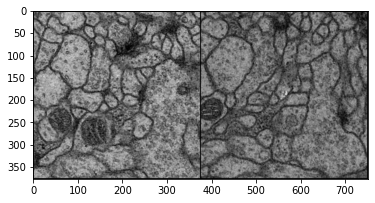

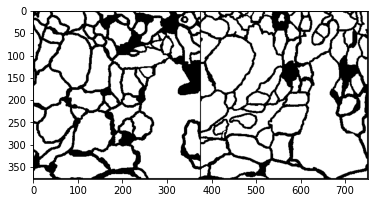

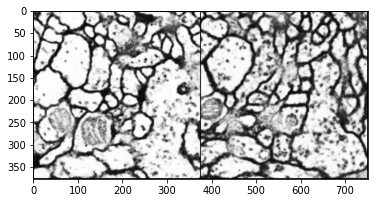


Epoch 100: Step 99: U-Net loss: 0.1370527595281601


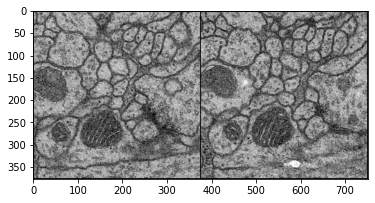

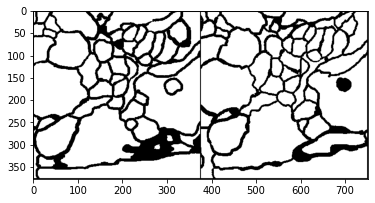

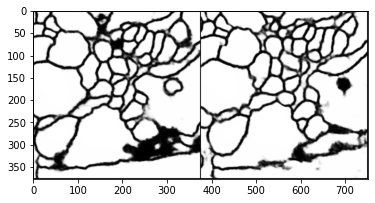


Epoch 150: Step 149: U-Net loss: 0.07253378629684448


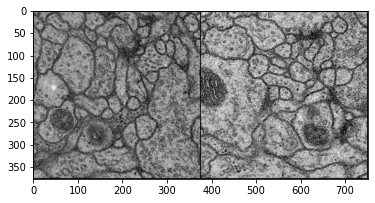

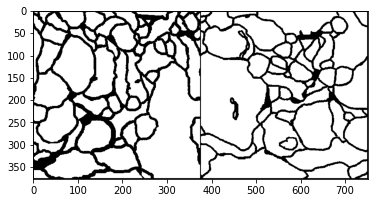

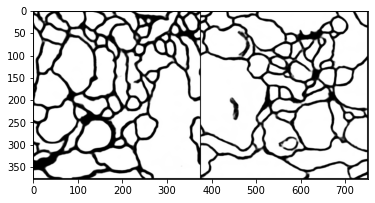

In [10]:
def train():
  dataloader = DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=True)
  unet = UNet(input_dim, label_dim).to(device)
  unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
  cur_step = 0
  for epoch in range(n_epochs): # 기존에 200 epoch 수행
    for real, labels in tqdm(dataloader):
      cur_batch_size = len(real)
      real = real.to(device)
      labels = labels.to(device)
      
      unet_opt.zero_grad()
      pred = unet(real)
      unet_loss = criterion(pred, labels)
      unet_loss.backward()
      unet_opt.step()

    if (epoch+1) % 50 == 0:
      print(f"Epoch {epoch+1}: Step {cur_step}: U-Net loss: {unet_loss.item()}")
      show_tensor_images(
          crop(real, torch.Size([len(real), 1, target_shape, target_shape])),
      )
      show_tensor_images(labels, size=(label_dim, target_shape, target_shape))
      show_tensor_images(torch.sigmoid(pred), size=(label_dim, target_shape, target_shape))
    cur_step += 1
train()